In [1]:
using Gen
using Distributions
using Random
using Plots
using Statistics
using GenParticleFilters

# Model

In [2]:
# Some constants
const dt = 0.1         # Simulation fidelty
const LANDMARK_X = 3.0 # Landmark position
const LANDMARK_Y = 3.0

3.0

In [3]:
@gen function robot_localization_model(
    dt::Float64,
    controls::Matrix{Float64},
    T::Int,                    
    sigma_v::Float64,          
    sigma_omega::Float64,       
    sigma_obs::Float64,
    sigma_theta::Float64       # NEW: heading observation noise (compass/IMU)
)
    # Initial pose
    x = @trace(normal(0.0, 10.0), :x0)
    y = @trace(normal(0.0, 10.0), :y0)
    theta = @trace(normal(0.0, 3.0), :theta0)
    
    # Range to landmark
    range0 = sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2)
    @trace(normal(range0, sigma_obs), (:obs, 0))
    
    # NEW: Heading observation (compass/IMU)
    @trace(normal(theta, sigma_theta), (:obs_theta, 0))
    
    for t in 1:T        
        # Odometry readings will be noisy
        v_noisy = @trace(normal(controls[t, 1], sigma_v), (:v_noise, t))
        omega_noisy = @trace(normal(controls[t, 2], sigma_omega), (:omega_noise, t))
        
        # Update pose
        theta = rem2pi(theta + omega_noisy * dt, RoundNearest)
        x = x + v_noisy * cos(theta) * dt
        y = y + v_noisy * sin(theta) * dt
        
        # Range observation
        expected_range = sqrt((LANDMARK_X - x)^2 + (LANDMARK_Y - y)^2)
        @trace(normal(expected_range, sigma_obs), (:obs, t))
        
        # NEW: Heading observation
        @trace(normal(theta, sigma_theta), (:obs_theta, t))
    end
    
    return (x, y, theta)
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Float64, Matrix{Float64}, Int64, Float64, Float64, Float64, Float64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing], Main.var"##robot_localization_model#277", Bool[0, 0, 0, 0, 0, 0, 0], false)

In [4]:
# Example impulse control generation. In a real-world setting we would first collect this data from the robot
# controls and then read it into the program rather than simulate it.
Random.seed!(419)

T = 200
sigma_v = 0.05
sigma_omega = 0.03
sigma_obs = 0.3
sigma_theta = 0.1  # NEW: heading observation noise (compass/IMU, ~6 degrees)
controls = zeros(T, 2)
turn_bias = 0.0

for t in 1:T
    # Occasionally change turn direction
    if t % 7 == 1 || rand() < 0.15
        turn_bias = randn() * 1.5
    end
    v = 0.35 + 0.1 * randn()
    omega = turn_bias + 0.8 * randn()
    controls[t, 1] = clamp(v, 0.2, 0.5)
    controls[t, 2] = clamp(omega, -2.0, 2.0)
end

In [5]:
# Generate a trace from the model (now with heading observations)
(trace, _) = generate(robot_localization_model, (dt, controls, T, sigma_v, sigma_omega, sigma_obs, sigma_theta))

# Extract ground truth initial state
x0_true = trace[:x0]
y0_true = trace[:y0]
theta0_true = trace[:theta0]

# Extract observations
observations = [trace[(:obs, t)] for t in 0:T]
observations_theta = [trace[(:obs_theta, t)] for t in 0:T]  # NEW: heading observations

println("Initial pose")
println("x0 = $(round(x0_true, digits=3))")
println("y0 = $(round(y0_true, digits=3))")
println("θ0 = $(round(theta0_true, digits=3)) rad")

println("\nObservations (range + heading)")
for t in 0:25:T
    println("t=$t: range=$(round(observations[t+1], digits=2))m, θ=$(round(observations_theta[t+1], digits=2))rad")
end

Initial pose
x0 = 2.359
y0 = -30.759
θ0 = -2.114 rad

Observations (range + heading)
t=0: range=33.17m, θ=-2.01rad
t=25: range=34.38m, θ=-1.63rad
t=50: range=33.84m, θ=2.04rad
t=75: range=33.54m, θ=2.74rad
t=100: range=33.31m, θ=2.06rad
t=125: range=34.41m, θ=-1.26rad
t=150: range=35.14m, θ=-1.39rad
t=175: range=35.44m, θ=-2.22rad
t=200: range=36.22m, θ=-1.58rad


In [6]:
# A naive function to reconstruct trajectory from observations. This just
# uses noisy observations, accumulating error.
function simulate_trajectory(trace, controls, T)
    # List of estimated poses 
    poses = zeros(T+1, 3)
    
    # Initial pose
    x = trace[:x0]
    y = trace[:y0]
    theta = trace[:theta0]
    poses[1, :] = [x, y, theta]
    
    for t in 1:T
        theta = rem2pi(theta + trace[(:omega_noise, t)] * dt, RoundNearest)
        x = x + trace[(:v_noise, t)] * cos(theta) * dt
        y = y + trace[(:v_noise, t)] * sin(theta) * dt
        poses[t+1, :] = [x, y, theta]
    end
    
    return poses
end

simulate_trajectory (generic function with 1 method)

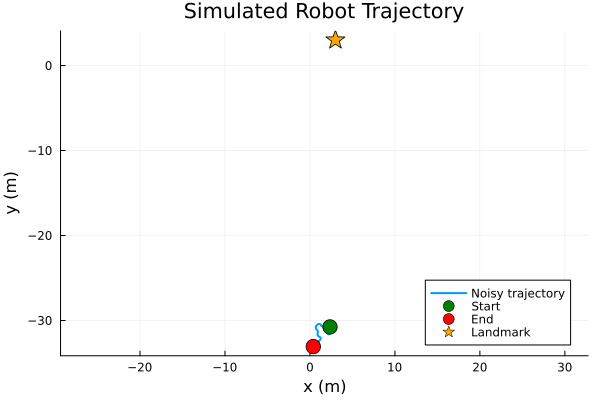

In [7]:
true_poses = simulate_trajectory(trace, controls, T)

# Plot the noisy trajectory
p = plot(
    true_poses[:, 1], true_poses[:, 2],
    label="Noisy trajectory",
    xlabel="x (m)", ylabel="y (m)",
    title="Simulated Robot Trajectory",
    linewidth=2,
    aspect_ratio=:equal,
    legend=:bottomright
)

# Mark start, end, and landmark
scatter!(p, [true_poses[1, 1]], [true_poses[1, 2]], label="Start", markersize=8, color=:green)
scatter!(p, [true_poses[end, 1]], [true_poses[end, 2]], label="End", markersize=8, color=:red)
scatter!(p, [LANDMARK_X], [LANDMARK_Y], label="Landmark", markersize=10, markershape=:star5, color=:orange)

display(p)

# Baselines

In [8]:
# Setup: Create observation constraints (range + heading)
obs_constraints = choicemap()
for t in 0:T
    obs_constraints[(:obs, t)] = observations[t+1]
    obs_constraints[(:obs_theta, t)] = observations_theta[t+1]  # NEW: heading observations
end

println("Ground truth initial pose:")
println("x0 = ", round(x0_true, digits=3))
println("y0 = ", round(y0_true, digits=3))
println("θ0 = ", round(theta0_true, digits=3))

Ground truth initial pose:
x0 = 2.359
y0 = -30.759
θ0 = -2.114


# MH Baseline

In [9]:
# Metropolis-Hastings with BLOCKED UPDATES (fair - also updates noise path)
# Must update both pose AND noise variables since noise is not constrained
Random.seed!(420)

(current_trace, _) = generate(robot_localization_model, (dt, controls, T, sigma_v, sigma_omega, sigma_obs, sigma_theta), obs_constraints)

# Selection for pose parameters
pose_sel = select(:x0, :y0, :theta0)

# Function to create selection for a subset of noise timesteps
function noise_sel(ts)
    addrs = Any[]
    for t in ts
        push!(addrs, (:v_noise, t))
        push!(addrs, (:omega_noise, t))
    end
    return select(addrs...)
end

num_mh_iterations = 200
mh_samples_x0 = Float64[]
mh_samples_y0 = Float64[]
mh_samples_theta0 = Float64[]
pose_accepted = 0
noise_accepted = 0

for i in 1:num_mh_iterations
    # Update pose
    (current_trace, acc_pose) = mh(current_trace, pose_sel)
    pose_accepted += acc_pose
    
    # Update ALL noise variables at once
    (current_trace, acc_noise) = mh(current_trace, noise_sel(1:T))
    noise_accepted += acc_noise
    
    push!(mh_samples_x0, current_trace[:x0])
    push!(mh_samples_y0, current_trace[:y0])
    push!(mh_samples_theta0, current_trace[:theta0])
    
    if i % 100 == 0
        println("MH Iteration $i: x0=$(round(current_trace[:x0], digits=3)), y0=$(round(current_trace[:y0], digits=3)), θ0=$(round(current_trace[:theta0], digits=3))")
    end
end

println("\nMH Results (blocked updates, fair comparison):")
println("Pose acceptance: $(round(pose_accepted/num_mh_iterations*100, digits=1))%")
println("Noise acceptance: $(round(noise_accepted/num_mh_iterations*100, digits=1))%")
println("x0: mean=$(round(mean(mh_samples_x0), digits=3)), true=$(round(x0_true, digits=3))")
println("y0: mean=$(round(mean(mh_samples_y0), digits=3)), true=$(round(y0_true, digits=3))")
println("θ0: mean=$(round(mean(mh_samples_theta0), digits=3)), true=$(round(theta0_true, digits=3))")

MH Iteration 100: x0=34.29, y0=0.252, θ0=6.226
MH Iteration 200: x0=5.901, y0=-30.596, θ0=-2.453

MH Results (blocked updates, fair comparison):
Pose acceptance: 2.0%
Noise acceptance: 6.0%
x0: mean=21.888, true=2.359
y0: mean=-11.519, true=-30.759
θ0: mean=2.735, true=-2.114


# IS Baseline

In [ ]:
# Importance Sampling Baseline
# Sample from prior, weight by likelihood of all observations
Random.seed!(420)
n_is_particles = 500

is_particles = Vector{Any}(undef, n_is_particles)
is_log_weights = zeros(n_is_particles)

for i in 1:n_is_particles
    (is_particles[i], is_log_weights[i]) = generate(robot_localization_model, 
        (dt, controls, T, sigma_v, sigma_omega, sigma_obs, sigma_theta), obs_constraints)
end

# Normalize weights and resample
is_log_total = logsumexp(is_log_weights)
is_weights = exp.(is_log_weights .- is_log_total)
is_indices = rand(Categorical(is_weights), n_is_particles)
is_particles = is_particles[is_indices]

# Extract samples
is_samples_x0 = [p[:x0] for p in is_particles]
is_samples_y0 = [p[:y0] for p in is_particles]
is_samples_theta0 = [p[:theta0] for p in is_particles]

x0_is = mean(is_samples_x0)
y0_is = mean(is_samples_y0)
theta0_is = mean(is_samples_theta0)

println("Importance Sampling Results:")
println("x0: mean=$(round(x0_is, digits=3)), true=$(round(x0_true, digits=3))")
println("y0: mean=$(round(y0_is, digits=3)), true=$(round(y0_true, digits=3))")
println("θ0: mean=$(round(theta0_is, digits=3)), true=$(round(theta0_true, digits=3))")
println("ESS: $(round(1/sum(is_weights.^2), digits=1)) / $n_is_particles")

Importance Sampling Results:
x0: mean=-26.83, true=2.359
y0: mean=-14.28, true=-30.759
θ0: mean=4.607, true=-2.114
ESS: 1.0 / 500


# Particle Filter Baseline

In [11]:
function particle_filter_localization(observations, observations_theta, dt, controls, T, n_particles;
                                      sigma_v, sigma_omega, sigma_obs, sigma_theta,
                                      ess_thresh=0.5)
    # constraints for obs addresses (range + heading)
    obs_choices = Vector{DynamicChoiceMap}(undef, T + 1)
    obs_choices[1] = choicemap((:obs, 0) => observations[1], (:obs_theta, 0) => observations_theta[1])
    for t in 1:T
        obs_choices[t + 1] = choicemap((:obs, t) => observations[t + 1], (:obs_theta, t) => observations_theta[t + 1])
    end

    # init at T=0
    state = pf_initialize(
        robot_localization_model,
        (dt, controls, 0, sigma_v, sigma_omega, sigma_obs, sigma_theta),
        obs_choices[1],
        n_particles
    )

    # only the 3rd argument (T) changes over time
    diffs = (NoChange(), NoChange(), UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())

    for t in 1:T
        if effective_sample_size(state) < ess_thresh * n_particles
            pf_resample!(state, :residual)
        end

        pf_update!(
            state,
            (dt, controls, t, sigma_v, sigma_omega, sigma_obs, sigma_theta),
            diffs,
            obs_choices[t + 1]
        )
    end

    return state
end


Random.seed!(420)

state_pf_basic = particle_filter_localization(observations, observations_theta, dt, controls, T, 50;
    sigma_v=sigma_v, sigma_omega=sigma_omega, sigma_obs=sigma_obs, sigma_theta=sigma_theta
)

x0_pf_basic     = mean(state_pf_basic, :x0)
y0_pf_basic     = mean(state_pf_basic, :y0)
theta0_pf_basic = mean(state_pf_basic, :theta0)

println("\nBasic Particle Filter Results:")
println("x0: mean=$(round(x0_pf_basic, digits=3)), true=$(round(x0_true, digits=3))")
println("y0: mean=$(round(y0_pf_basic, digits=3)), true=$(round(y0_true, digits=3))")
println("θ0: mean=$(round(theta0_pf_basic, digits=3)), true=$(round(theta0_true, digits=3))")



Basic Particle Filter Results:
x0: mean=-14.411, true=2.359
y0: mean=-31.662, true=-30.759
θ0: mean=-0.256, true=-2.114


In [ ]:
function custom_particle_filter(
    observations, observations_theta, dt, controls, T, n_particles;
    sigma_v, sigma_omega, sigma_obs, sigma_theta,
    ess_thresh=0.3,               
    min_steps_before_resample=20,
    rejuv_steps=10,               
    σ_x_prop=1.0, 
    σ_θ_prop=0.3
)
    obs_choices = Vector{DynamicChoiceMap}(undef, T + 1)
    obs_choices[1] = choicemap((:obs, 0) => observations[1], (:obs_theta, 0) => observations_theta[1])
    for t in 1:T
        obs_choices[t + 1] = choicemap((:obs, t) => observations[t + 1], (:obs_theta, t) => observations_theta[t + 1])
    end

    state = pf_initialize(
        robot_localization_model,
        (dt, controls, 0, sigma_v, sigma_omega, sigma_obs, sigma_theta),
        obs_choices[1],
        n_particles
    )

    diffs = (NoChange(), NoChange(), UnknownChange(), NoChange(), NoChange(), NoChange(), NoChange())
    
    n_resamples = 0

    for t in 1:T
        ess = effective_sample_size(state)
        
        # Only resample after enough steps AND when ESS is low
        if t >= min_steps_before_resample && ess < ess_thresh * n_particles
            pf_resample!(state, :residual)
            n_resamples += 1
            
            # Aggressive rejuvenation with RANDOM WALK proposals (not prior)
            for _ in 1:rejuv_steps
                for i in 1:n_particles
                    tr = state.traces[i]
                    
                    # Propose random walk perturbation
                    x0_curr = tr[:x0]
                    y0_curr = tr[:y0]
                    θ0_curr = tr[:theta0]
                    
                    x0_prop = x0_curr + σ_x_prop * randn()
                    y0_prop = y0_curr + σ_x_prop * randn()
                    θ0_prop = rem2pi(θ0_curr + σ_θ_prop * randn(), RoundNearest)
                    
                    # MH update with constraint
                    proposal = choicemap(:x0 => x0_prop, :y0 => y0_prop, :theta0 => θ0_prop)
                    (new_tr, w, _, _) = update(tr, get_args(tr), map(_ -> NoChange(), get_args(tr)), proposal)
                    
                    # Accept/reject (symmetric proposal, so just weight ratio)
                    if log(rand()) < w
                        state.traces[i] = new_tr
                    end
                end
            end
        end

        pf_update!(state, (dt, controls, t, sigma_v, sigma_omega, sigma_obs, sigma_theta), diffs, obs_choices[t + 1])

        if t % (T÷5) == 0
            xs = [tr[:x0] for tr in state.traces]
            println("t=$t: ESS=$(round(ess,digits=1)), unique=$(length(unique(round.(xs, digits=1)))), " *
                    "x0=$(round(mean(state,:x0),digits=2)), y0=$(round(mean(state,:y0),digits=2))")
        end
    end
    
    return state
end

# Run improved PF
Random.seed!(420)
state_improved = custom_particle_filter(observations, observations_theta, dt, controls, T, 500;
    sigma_v=sigma_v, sigma_omega=sigma_omega, sigma_obs=sigma_obs, sigma_theta=sigma_theta,
    min_steps_before_resample=20,  # Key: wait for motion info
    ess_thresh=0.3,
    rejuv_steps=30,
    σ_x_prop=0.5,
    σ_θ_prop=0.2
)

x0_improved = mean(state_improved, :x0)
y0_improved = mean(state_improved, :y0)

println("\Custom PF Results:")
println("x0: $(round(x0_improved, digits=3)) (true: $(round(x0_true, digits=3)))")
println("y0: $(round(y0_improved, digits=3)) (true: $(round(y0_true, digits=3)))")
err = sqrt((x0_improved-x0_true)^2 + (y0_improved-y0_true)^2 + (theta0_improved-theta0_true)^2)
println("RMSE: $(round(err, digits=3))")

t=40: ESS=186.6, unique=77, x0=0.87, y0=-30.59
t=80: ESS=200.0, unique=73, x0=0.72, y0=-30.58
t=120: ESS=308.1, unique=46, x0=1.76, y0=-30.62
t=160: ESS=457.0, unique=29, x0=1.63, y0=-30.62
t=200: ESS=372.6, unique=23, x0=1.35, y0=-30.63
Total resamples: 7

Improved PF Results:
x0: 1.353 (true: 2.359)
y0: -30.632 (true: -30.759)
RMSE: 1.018


# Comparison

In [24]:
println("=================================")
println("INFERENCE RESULTS COMPARISON")
println("=================================")

println("\nGround Truth: x0=$(round(x0_true, digits=3)), y0=$(round(y0_true, digits=3))")

println("\n1. MH:")
mh_x0 = mean(mh_samples_x0)
mh_y0 = mean(mh_samples_y0)
mh_theta0 = mean(mh_samples_theta0)
mh_err = sqrt((mh_x0-x0_true)^2 + (mh_y0-y0_true)^2)
println("  Estimate: x0=$(round(mh_x0, digits=3)), y0=$(round(mh_y0, digits=3))")
println("  Std: x0=$(round(std(mh_samples_x0), digits=3)), y0=$(round(std(mh_samples_y0), digits=3)), θ0=$(round(std(mh_samples_theta0), digits=3))")
println("  RMSE: $(round(mh_err, digits=3))")

println("\n2. IS:")
is_err = sqrt((x0_is-x0_true)^2 + (y0_is-y0_true)^2)
println("  Estimate: x0=$(round(x0_is, digits=3)), y0=$(round(y0_is, digits=3))")
println("  Std: x0=$(round(std(is_samples_x0), digits=3)), y0=$(round(std(is_samples_y0), digits=3))")
println("  RMSE: $(round(is_err, digits=3))")

println("\n3. Baseline PF:")
pf_basic_samples_x0 = [tr[:x0] for tr in state_pf_basic.traces]
pf_basic_samples_y0 = [tr[:y0] for tr in state_pf_basic.traces]
pf_basic_samples_theta0 = [tr[:theta0] for tr in state_pf_basic.traces]
pf_basic_err = sqrt((x0_pf_basic-x0_true)^2 + (y0_pf_basic-y0_true)^2)
println("  Estimate: x0=$(round(x0_pf_basic, digits=3)), y0=$(round(y0_pf_basic, digits=3))")
println("  Std: x0=$(round(std(pf_basic_samples_x0), digits=3)), y0=$(round(std(pf_basic_samples_y0), digits=3)), θ0=$(round(std(pf_basic_samples_theta0), digits=3))")
println("  RMSE: $(round(pf_basic_err, digits=3))")

println("\n4. Custom PF:")
pf_samples_x0 = [tr[:x0] for tr in state_improved.traces]
pf_samples_y0 = [tr[:y0] for tr in state_improved.traces]
pf_samples_theta0 = [tr[:theta0] for tr in state_improved.traces]
pf_err = sqrt((x0_improved-x0_true)^2 + (y0_improved-y0_true)^2)
println("  Estimate: x0=$(round(x0_improved, digits=3)), y0=$(round(y0_improved, digits=3))")
println("  Std: x0=$(round(std(pf_samples_x0), digits=3)), y0=$(round(std(pf_samples_y0), digits=3)), θ0=$(round(std(pf_samples_theta0), digits=3))")
println("  RMSE: $(round(pf_err, digits=3))")

INFERENCE RESULTS COMPARISON

Ground Truth: x0=2.359, y0=-30.759

1. MH:
  Estimate: x0=21.888, y0=-11.519
  Std: x0=14.364, y0=15.269, θ0=4.172
  RMSE: 27.415

2. IS:
  Estimate: x0=-26.83, y0=-14.28
  Std: x0=0.0, y0=0.0
  RMSE: 33.52

3. Baseline PF:
  Estimate: x0=-14.411, y0=-31.662
  Std: x0=0.0, y0=0.0, θ0=0.0
  RMSE: 16.795

4. Custom PF:
  Estimate: x0=1.353, y0=-30.632
  Std: x0=0.374, y0=0.054, θ0=0.01
  RMSE: 1.015
